In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
class Planeta: # minisculas: vectores en el tiempo, mayusculas: vectores instantaneos
    
    def __init__(self, e, a, t): # Excentricidad y semi eje mayor
        
        self.t = t
        self.dt = t[1] - t[0] # Paso del tiempo
        
        self.e = e # Excentricidad
        self.a_ = a # Semi-eje mayor
        
        self.G = 4*np.pi**2 # Unidades gaussianas
        
        self.r = np.zeros(3) # x,y,z
        self.v = np.zeros_like(self.r)
        self.a = np.zeros_like(self.r)
        
        # Condiciones iniciales
        self.r[0] = self.a_*(1-self.e) # 1 - excentricidad del perihelio del planeta
        self.v[1] = np.sqrt(self.G*(1+self.e) / (self.a_*(1.-self.e))) # se conserva el momento angular
        
        # Historial
        self.R = np.zeros((len(t), len(self.r)))
        self.V = np.zeros_like(self.R)
        
        self.rp = self.r # Valor del pasado
        
    def GetAceleration(self):
        d = np.linalg.norm(self.r)
        self.a = -self.G/d**3*self.r
    
    def Evolution(self, i):
        
        self.SetPosition(i) # para ir guardando
        self.SetVelocity(i)
        self.GetAceleration()
        
        if i==0:
            self.r = self.rp + self.v*self.dt # euler
        
        else:
            self.rf = 2*self.r - self.rp + self.a*self.dt**2 # valor futuro -> Integracion de Verlet
            self.v = (self.rf - self.rp)/(2*self.dt) # definicion derivada central
            
            self.rp = self.r # mi pasado ahora es el presente del paso anterior
            self.r = self.rf # mi presente ahora es el futuro del paso anterior
    
    def SetPosition(self,i):
        self.R[i] = self.r
        
    def SetVelocity(self,i):
        self.V[i] = self.v
        
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
    
    def GetPerihelio(self):
        Dist = np.linalg.norm(self.R, axis = 1)
        timeup = []
        
        for i in range(1,len(Dist)-1):
            if Dist[i] < Dist[i-1] and Dist[i] < Dist[i+1]:
                timeup.append(self.t[i])
            
        return timeup

In [3]:
def GetPlanetas(t):
    
    Mercurio = Planeta(0.2056,0.387,t)
    Venus = Planeta(0.0067,0.7233,t)
    Tierra = Planeta(0.01671, 1., t)
    Marte = Planeta(0.093315, 1.523679, t)
    Jupiter = Planeta(0.0487749764, 5.204267, t)
    
    return [Mercurio,Venus,Tierra,Marte,Jupiter]

In [15]:
dt = 0.001
tmax = 20 # 1 año jupiter maso 12 años tierra
t = np.arange(0., tmax, dt)
Planetas = GetPlanetas(t)

In [16]:
def RunSimulation(t,Planetas):
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        #print(it)
        
        for i in range(len(Planetas)):
            Planetas[i].Evolution(it)
            
    return Planetas

In [21]:
Planetas = RunSimulation(t,Planetas)

Running simulation: 100%|██████████| 20000/20000 [00:00<00:00, 27662.07 Steps/s]


In [22]:
scale = 10
t1 = t[::scale]

In [23]:
plt.plot(Planetas[0].GetPosition()[:,0],Planetas[0].GetPosition()[:,1])

In [24]:
Planetas[4].GetPerihelio()

[3.741, 15.613]

<IPython.core.display.Javascript object>


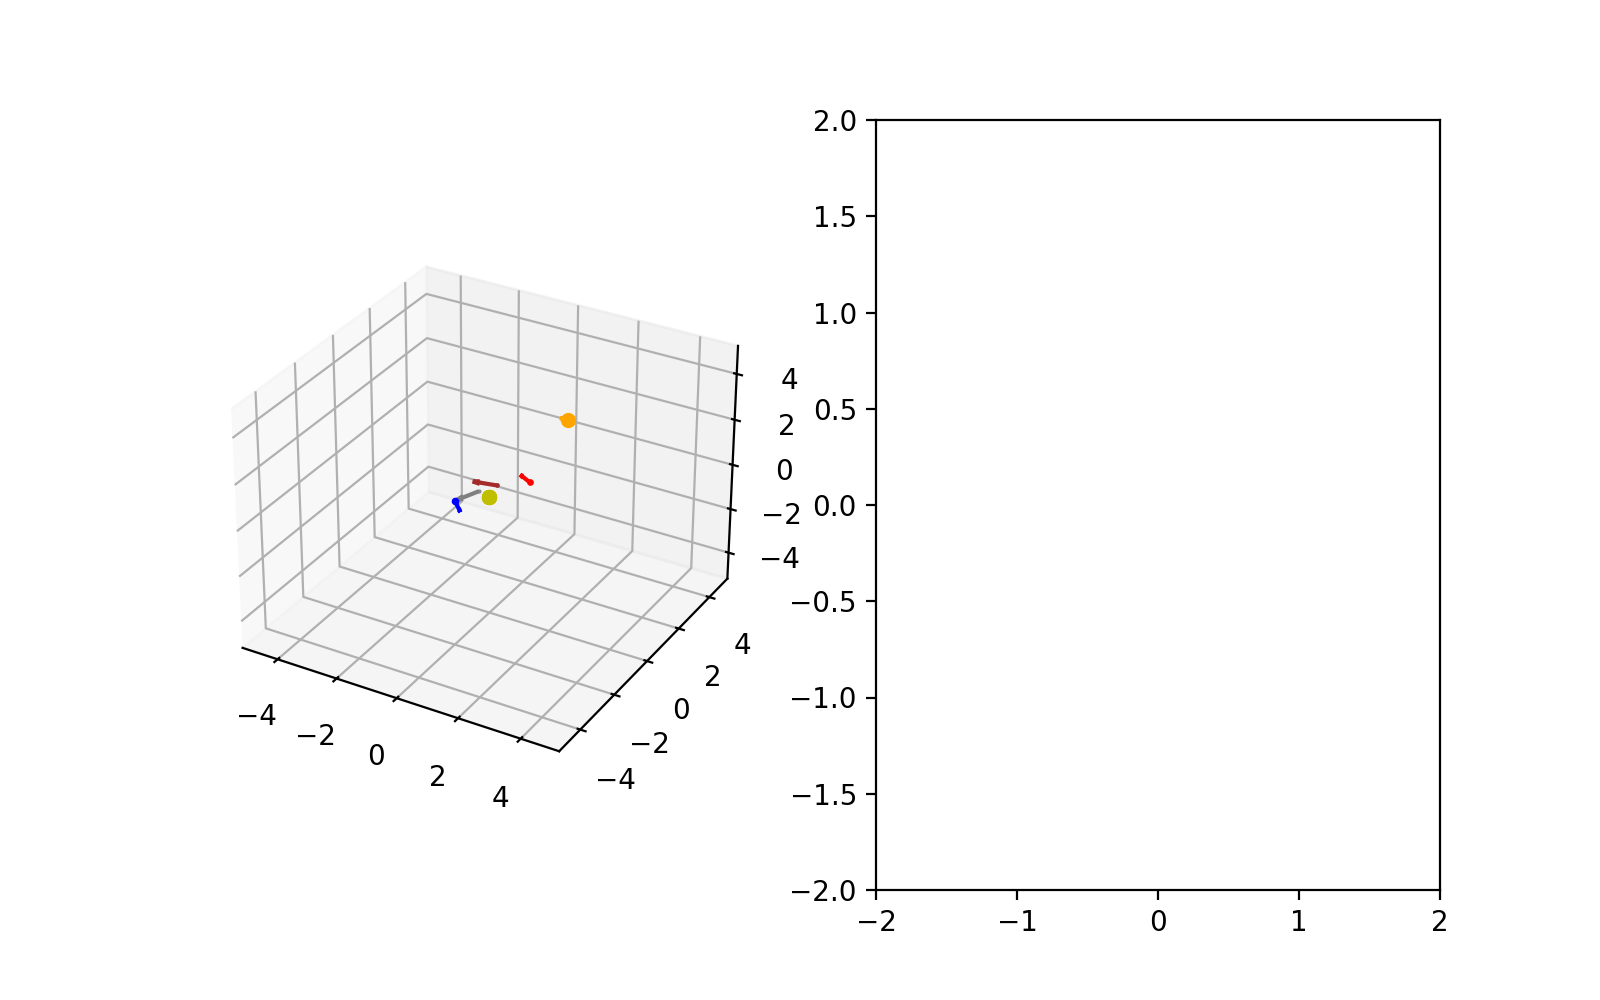

In [13]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(121,projection='3d')
ax1 = fig.add_subplot(122)

colors = ['gray','brown','b','r','orange']
size = [0.2, 0.5, 3, 2, 20]

def init():
    
    ax.clear()
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_zlim(-5,5)
    
    ax1.clear()
    ax1.set_xlim(-2,2)
    ax1.set_ylim(-2,2) 
    
def Update(i):
    
    init()
    
    for j, p in enumerate(Planetas):
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        z = p.GetPosition(scale)[i,2]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        vz = p.GetVelocity(scale)[i,2]
    
        ax.scatter(0, 0, 0, s = 20,color='y')
        ax.quiver(x,y,z,vx,vy,vz, color=colors[j], length=0.1)
        
        ax.scatter(x,y,z, s = size[j],color=colors[j])
        
    
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)